# Biased coins and truncated data

I was inspired by a recent paper by [Boubert & Everall 2020](https://arxiv.org/abs/2005.08983) to consider
the inference of the probability of a biased coin.

The problem is the following: given a table of $N$ coin flip experiments where you have, for each experiment,
the number of times it was flipped and the number of times it showed heads, we want to infer
the probability that this coin shows head.

Let's call
- $i = 1,\ldots,N$: index of the experiments
- $n_i$: the number of times the coin was flipped in the $i$-th experiment
- $k_i$: the number of times it showed head in the $i$-th experiment
- $\theta$: the probability that this coin shows head (what we want to know).

The probability that the coin shows head $k$ times is described by a Binomial distribution, $B(n_i,\,\theta)$:

$$k_i \sim B(n_i,\,\theta)$$

For the prior of $\theta$, let's assume uniform between 0 and 1.

The model is quite simple in stan.

In [1]:
import pystan
import numpy as np
from scipy import stats
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('smoh')

In [2]:
model = pystan.StanModel(model_code='''
data {
    // number of coins
    int<lower=0> N;
    // number of flips
    int n[N];
    // number of heads
    int k[N];
}
parameters {
    real<lower=0,upper=1> theta;
}
model {
    for (i in 1:N) {
        k[i] ~ binomial(n[i], theta);
    }
}
''')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1ae8f841dadf99bac88119a5390bb387 NOW.


We can simulate data with `scipy.stats.binom`.
If we have no truncation on the data, different experiments do not matter.
If the coin was flipped 20 times in a hundred experiment, it is the same as one experiment of flipping it
2000 times.

In [3]:
theta = 0.63
N = 100
n_i = np.ones(N, dtype=int)*20
k_i = stats.binom.rvs(n=n_i, p=theta)
data = dict(N=N, n=n_i, k=k_i)

# combine all experiment to one
data_one = dict(N=1, n=[n_i.sum()], k=[k_i.sum()])

In [4]:
ropt = model.optimizing(data=data)
ropt_one = model.optimizing(data=data_one)
print('theta from {} experiments of {} flips = {}'.format(N, n_i[0],ropt['theta']))
print('theta from {} experiments of {} flips = {}'.format(1, n_i.sum(),ropt['theta']))

theta from 100 experiments of 20 flips = 0.6589996177901194
theta from 1 experiments of 2000 flips = 0.6589996177901194


In fact, the uniform distribution is a special case of Beta distribution $\mathrm{Beta}(\alpha,\,\beta)$ when
$\alpha=\beta=1$.
Because Beta distributions are conjugate priors of Binomial distribution,
the posterior distribution is also a Beta distribution with
$\mathrm{Beta}(\alpha+k,\,\beta+n-k)$ where $n=\Sigma n_i$ and $k=\Sigma k_i$.
The posterior mean is $\frac{\alpha+k}{\alpha+\beta+n}$, which approaches $\frac{k}{n}$ as $n \to \infty$, as it should intuitively.

We can check that stan posterior sample matches this expectation.

In [5]:
r1 = model.sampling(data=data)
r2 = model.sampling(data=data_one)

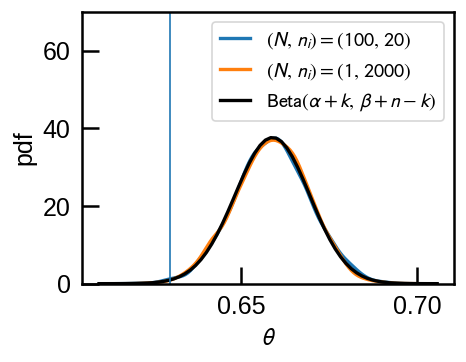

In [6]:
fig, ax = plt.subplots(figsize=(4,3))
sns.kdeplot(r1['theta'], label='$(N,\,n_i)=(100,\,20)$',ax=ax)
sns.kdeplot(r2['theta'], label='$(N,\,n_i)=(1,\,2000)$', ax=ax)

x = np.linspace(*ax.get_xlim(), 64)
pdfx= stats.beta(1+k_i.sum(), 1+n_i.sum()-k_i.sum()).pdf(x)
ax.plot(x, pdfx, 'k-', label=r'$\mathrm{Beta}(\alpha+k,\,\beta+n-k)$');

ax.axvline(theta, lw=1)
ax.legend(loc='upper right', fontsize=12);
ax.set(ylim=(0,70), xlabel=r'$\theta$', ylabel='pdf');

Now, what if it turns out that the experiment is not reported at all when the number of times it showed head is less than $k_t$ times?
As explained in [Boubert & Everall 2020](https://arxiv.org/abs/2005.08983), we need to
adjust the likelihood function by dividing it by
$$\int_{k_t}^n p(k\,|n,\,\theta)$$
(so that it will integrate to 1 from $k_t$ not $1$).

Stan supports truncated data for 1D distributions[1]
so the modification is simple:

[1] https://mc-stan.org/docs/2_20/stan-users-guide/truncated-data-section.html

In [7]:
modelth = pystan.StanModel(model_code='''
data {
    // number of coins
    int<lower=0> N;
    // number of flips
    int n[N];
    // number of heads
    int k[N];
    // truncation threshold
    int kthresh;
}
parameters {
    real<lower=0,upper=1> theta;
}
model {
    for (i in 1:N) {
        k[i] ~ binomial(n[i], theta) T[kthresh,];
    }
}
''')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_881cc4f08b358f1b7d00072aacadc09b NOW.


Now, because a record of an experiment might be missing,
it is no longer valid to treat the sum of experiments as one 'master' experiment.

What do we expect for our inference of $\theta$ if we use the truncated data
yet use the old (wrong) model that does not account for missing data?
The data will be biased towards high $k_i$ and this will bias $\theta$ high as well.

Let's simulate this truncated data as well and see if this is the case.

In [33]:
theta = 0.63
N = 100
n_i = np.ones(N, dtype=int)*10
k_i = stats.binom.rvs(n=n_i, p=theta)
k_t = 5

# repeat until i have N experiments replacing truncated
while (k_i<k_t).sum()>0:
    bad = k_i < k_t
    print('replacing {}'.format(bad.sum()))
    k_i_new = stats.binom.rvs(n=n_i[bad], p=theta)
    k_i[bad] = k_i_new
data = dict(N=N, n=n_i, k=k_i,)

replacing 13
replacing 2


In [34]:
r1 = model.sampling(data=data)
data['kthresh'] = k_t
r2 = modelth.sampling(data=data)

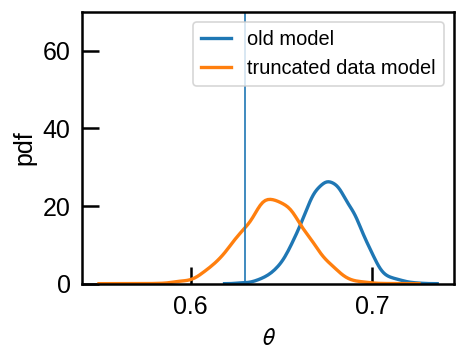

In [35]:
fig, ax = plt.subplots(figsize=(4,3))
sns.kdeplot(r1['theta'], label='old model',ax=ax)
sns.kdeplot(r2['theta'], label='truncated data model', ax=ax)

ax.axvline(theta, lw=1)
ax.legend(loc='upper right', fontsize=12);
ax.set(ylim=(0,70), xlabel=r'$\theta$', ylabel='pdf');

Indeed, the old model that does not account for missing data infers
a higher $\theta$ than we should whereas the new model recovers the correct value.

This will be more prounounced as we repeat more experiments and the posterior
distribution gets sharper.

In [36]:
rs_old = []
rs_new = []
# for N in [100, 1000, 10000]:
for N in [100, 1000]:
    n_i = np.ones(N, dtype=int)*10
    k_i = stats.binom.rvs(n=n_i, p=theta)
    k_t = 5

    # repeat until i have N experiments replacing truncated
    while (k_i<k_t).sum()>0:
        bad = k_i < k_t
        k_i_new = stats.binom.rvs(n=n_i[bad], p=theta)
        k_i[bad] = k_i_new
    data_tmp = dict(N=N, n=n_i, k=k_i,)

    %time r1tmp = model.sampling(data=data_tmp)
    data_tmp['kthresh'] = k_t
    %time r2tmp = modelth.sampling(data=data_tmp)
    rs_old.append(r1tmp)
    rs_new.append(r2tmp)

CPU times: user 89.2 ms, sys: 523 ms, total: 612 ms
Wall time: 819 ms
CPU times: user 96 ms, sys: 438 ms, total: 534 ms
Wall time: 1.59 s
CPU times: user 97 ms, sys: 446 ms, total: 543 ms
Wall time: 1.19 s
CPU times: user 124 ms, sys: 485 ms, total: 609 ms
Wall time: 8.68 s


/home/soh/.conda/envs/nitro/lib/python3.7/site-packages/seaborn/distributions.py:323: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


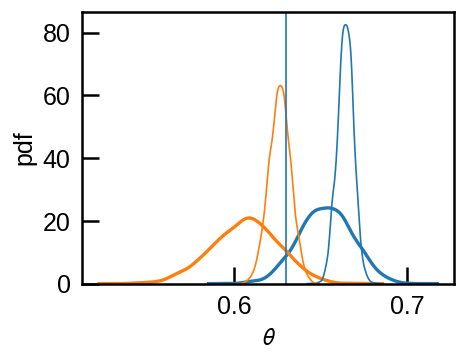

In [12]:
fig, ax = plt.subplots(figsize=(4,3))
for i, (r1, r2) in enumerate(zip(rs_old, rs_new)):
    sns.kdeplot(r1['theta'], c='C0', lw=1 if i>0 else 2)
    sns.kdeplot(r2['theta'], ax=ax, c='C1',lw=1 if i>0 else 2)

ax.axvline(theta, lw=1)
ax.set(xlabel=r'$\theta$', ylabel='pdf');

The correct model converges to the true value while the wrong model will bias $\theta$ higher.

Note that if $\theta n_i$ (the expectation value of $k_i$ for $i$-th experiment) is much larger than
the threshold $k_t$, than the threshold is not going to filter out much data and
it would not matter if we use the corret model that accounts for the missing data or not.

What is acutally happening here?

The posterior distribution is

$$ p(\theta\,| \{n_i,\,k_i\}) \propto \prod _{i=1}^{N}  p (k_i \,|\,n_i,\,\theta) p(\theta) $$
where
$$p (k_i\,|\,n_i,\,\theta) = \frac{1}{1 - p(k_i \lt 5\,|\,n_i,\,\theta)} {n \choose k} \theta^k \theta^{n-k}$$

Assuming uniform prior, $p(\theta) = 1$ between 0 and 1, let's have a look at
what the normalization factor that applies the data truncation does.

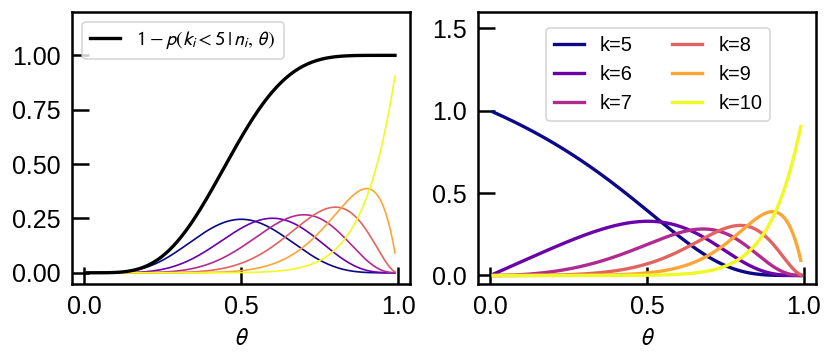

In [75]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,3))
thetas = np.linspace(0.01,0.99,201)
pdfs=[]
n_flip = 10

for k in np.arange(k_t, 11):
    ax1.plot(thetas, stats.binom.pmf(k, n_flip, thetas), '-',lw=1,
             c=plt.cm.plasma((k-k_t)/(n_flip-k_t)));

I = 1-stats.binom.cdf(k_t-1 , n_flip, thetas)
ax1.plot(thetas, I, c='k', label=r'$1 - p(k_i < 5\,|\,n_i,\,\theta)$')
ax1.legend(loc='upper left', fontsize=12)
ax1.set(ylim=(None, 1.2))
for k in np.arange(k_t, 11):
    ax2.plot(thetas, stats.binom.pmf(k, 10, thetas)/I, '-', lw=2,
             c=plt.cm.plasma((k-k_t)/(n_flip-k_t)), label='k={}'.format(k));

ax2.legend(loc=(0.2,0.6), fontsize=12, ncol=2)
ax2.set(ylim=(None, 1.6)) 
for cax in (ax1, ax2):
    cax.set(xlabel=r'$\theta$')

For each possible $k_i \ge k_t = 5$ upto $n_i=10$,
the plot above shows the usual Binomial probability mass function (pmf) on the left.
The normalization factor is the reciprocal of the black line, which shows $1 - p(k_i \lt 5\,|\,n_i,\,\theta)$.
After the correction is applied, each pmf on the left of the same color is changed to that on the right.

In essense, the correction compensates for the fact that
the observation of $k_i$ heads may be statistical fluctuation above the mean at lower $\theta$.
We see that if $\theta$ is large enough to put typical number of $k_i$ above the threshold,
the correction disappears, i.e., it goes to 1, and
it is most dramatic for low $\theta$ at $k_i$ near the threshold.

Since we know the shape of the pdf for each $i$, we can multiply all pdf
to get the posterior (without normalization).

In [38]:
from scipy.special import logsumexp
pdfs=[]
for n_flip, k in zip(data['n'], data['k']):
    I = 1-stats.binom.cdf(k_t-1, n_flip, thetas)
    pdfs.append(stats.binom.pmf(k, n_flip, thetas)/I)

a=np.log(np.array(pdfs)).sum(axis=0)
imax = a.argmax()
# np.exp(-9)=0.0001234...; ignore ranges where pdf falls below this time the peak value
ii = a-a[imax]>-9   
a-=a.max()   # arbitrary scaling...
a=np.exp(a)
a[~ii]=0

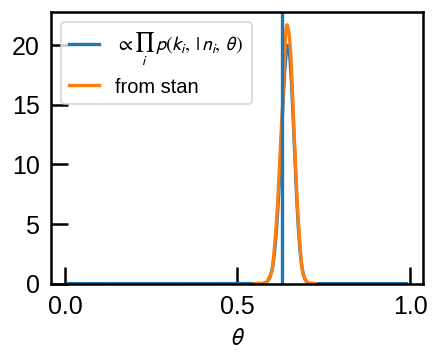

In [39]:
fig, ax =plt.subplots(figsize=(4,3))
plt.plot(thetas, a*20, label=r'$\propto \prod_i \, p(k_i,\,|\,n_i,\,\theta)$')
sns.kdeplot(r2['theta'], label='from stan')
plt.axvline(theta)
plt.legend(fontsize=12);
plt.xlabel(r'$\theta$');

The two match as they should.

If there is an absolute threhold $k>k_t$, this will affect experiments where you expect $k$ to be near $k_t$ whereas large-$n_i$ experiments will not be affected.

Let's carry out a comparison to explore this: collect 1000 experiments in total, but
- in case 1: throw 10 times in 100 experiments
- in case 2: throw 100 times in 10 experiments

and set the threshold at $k_t = 5$ with $\theta=0.2$ (Deliberately chosen to see the effect of data truncation).

Although the total number of flips is the same,
there is much higher chance that all experiments in case 1 will not be reported as we would typically expect $n_i \theta = 2$ heads
with some spread.

In [40]:
def simulate(theta, N, n, k_t):
    '''
    Throw n flips each time.
    Threshold at k>=k_t.
    Fill until I have N records.
    '''
    n_i = np.ones(N, dtype=int)*n
    k_i = stats.binom.rvs(n=n_i, p=theta)
    
    nbads = 0
    # repeat until i have N experiments replacing truncated
    while (k_i<k_t).sum()>0:
        bad = k_i < k_t
        nbads += bad.sum()
        k_i_new = stats.binom.rvs(n=n_i[bad], p=theta)
        k_i[bad] = k_i_new
    print("theta={:.3f} N={:5d} n={:5d} k_t={:3d}: replaced {}".format(
        theta, N, n, k_t, nbads))
    return dict(N=N, n=n_i, k=k_i,kthresh=k_t)

In [41]:
theta=0.2
data1 = simulate(theta, 100, 10, 5)
data2 = simulate(theta, 10, 100, 5)
data3 = simulate(theta, 500, 10, 5)

theta=0.200 N=  100 n=   10 k_t=  5: replaced 2893
theta=0.200 N=   10 n=  100 k_t=  5: replaced 0
theta=0.200 N=  500 n=   10 k_t=  5: replaced 15411


Indeed, to collect 100, there were 2893 experiments that were truncated because $k_i$ did not make the threshlold.

In [42]:
result = {}
result['$(N,\,n_i)$ = (100, 10)'] = modelth.sampling(data=data1)
result['$(N,\,n_i)$ = (10, 100)'] = modelth.sampling(data=data2)
result['$(N,\,n_i)$ = (500, 10)'] = modelth.sampling(data=data3)

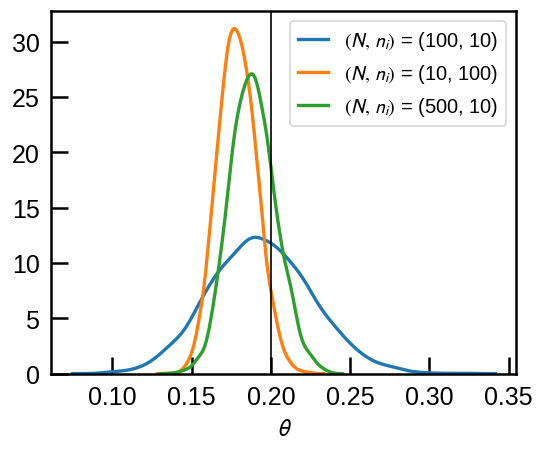

In [43]:
fig, ax = plt.subplots(figsize=(5,4))
for k, v in result.items():
    sns.kdeplot(v['theta'], label=k, ax=ax)
ax.axvline(theta, c='k', lw=1);
ax.legend(loc='upper right', fontsize=12);
ax.set(xlabel=r'$\theta$');

As expected, in this case it's better to have $(N,\,n_i)=(10,\,100)$ than
$(N,\,n_i)=(100,\,10)$ although the total number of flips is the same.
However, even in the case where each experiment is at the risk of being discarded due to
data truncation, if we have enough data and we account for the data truncation,
we can still recover more $\theta$ more precisely: we start to recover $\theta$ with
comparable confidence interval when 10-flip experiment records are collected 5 times more ($N=500$).

This cross-over between large-$N$-small-$n_i$ and small-$N$-large-$n_i$
depends on values of $\theta$ and $k_t$.